# CP600 - Practical Algorithm Design

# Project - Safety Helmet Detection using Deep Learning

#### Framework: TensorFlow Object detection API
#### Model: Faster-R-CNN-InceptionV2
#### Dataset: [View Hard hat workers Dataset](https://public.roboflow.com/object-detection/hard-hat-workers/2)

## To check alloted GPU details

In [1]:
!nvidia-smi

Sat Dec 12 17:04:08 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 1. Installing requirements for project

In [2]:
!pip install tensorflow_gpu==1.15
!pip install tf_slim
!pip install lvis

     |████████████████████████████████| 411.5MB 39kB/s 
     |████████████████████████████████| 512kB 52.6MB/s 
     |████████████████████████████████| 51kB 8.2MB/s 
     |████████████████████████████████| 3.8MB 46.2MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7542 sha256=b1085745e88e58d2ae04f4961ebb4d52fda605280430c1288325f7b3738fb7e5
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow 2.3.0 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow 2.3.0 has requirement tensorboard<3,>=2.3.0, but you'll have tensorboard 1.15.0 which is incompatible.
ERROR: tensorflow 2.3.0 has requirement tensorflow-estimator<2.4.0,>=2.3.0, but you'll have tensorflow-estimator 1.15.1 which is incompatible.
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing i

In [5]:
%cd /content
!git clone --quiet https://github.com/tensorflow/models.git

!apt-get install -qq protobuf-compiler python-pil python-lxml python-tk

!pip install -q Cython contextlib2 pillow lxml matplotlib

!pip install -q pycocotools

%cd /content/models/research
!protoc object_detection/protos/*.proto --python_out=.

import os
os.environ['PYTHONPATH'] += ':/content/models/research/:/content/models/research/slim/'

!python object_detection/builders/model_builder_test.py

/content
E: Failed to fetch http://security.ubuntu.com/ubuntu/pool/main/l/lxml/python-lxml_4.2.1-1ubuntu0.1_amd64.deb  404  Not Found [IP: 91.189.88.152 80]
E: Unable to fetch some archives, maybe run apt-get update or try with --fix-missing?
/content/models/research


## Configs and Hyperparameters

Picking up pretrained model from [Tensorflow detection model zoo: COCO-trained models](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md#coco-trained-models), as well as their pipline config files in [object_detection/samples/configs/](https://github.com/tensorflow/models/tree/master/research/object_detection/samples/configs).

In [3]:
repo_url = 'https://github.com/roboflow-ai/tensorflow-object-detection-faster-rcnn'

#training steps
num_steps = 100000

# Number of evaluation steps.
num_eval_steps = 50

MODELS_CONFIG = {
    'faster_rcnn_inception_v2': {
        'model_name': 'faster_rcnn_inception_v2_coco_2018_01_28',
        'pipeline_file': 'faster_rcnn_inception_v2_pets.config',
        'batch_size': 1
    }
}

model = 'faster_rcnn_inception_v2'

# object detection model.
MODEL = MODELS_CONFIG[model]['model_name']

# pipline file in tensorflow object detection API.
pipeline_file = MODELS_CONFIG[model]['pipeline_file']

# Training batch size that fits in Colabe's memory
batch_size = MODELS_CONFIG[model]['batch_size']

## Cloning the `tensorflow-object-detection` repository

In [4]:
import os

%cd /content
repo_dir_path = os.path.abspath(os.path.join('.', os.path.basename(repo_url)))

!git clone {repo_url}
%cd {repo_dir_path}
!git pull

/content
Cloning into 'tensorflow-object-detection-faster-rcnn'...
remote: Enumerating objects: 885, done.
remote: Total 885 (delta 0), reused 0 (delta 0), pack-reused 885
Receiving objects: 100% (885/885), 24.84 MiB | 35.82 MiB/s, done.
Resolving deltas: 100% (412/412), done.
/content/tensorflow-object-detection-faster-rcnn
Already up to date.


## Prepare `tfrecord` files

### Mount the drive

In [7]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Now, put the downloaded dataset in below path in drive
- Path to download data: [Hard hat workers Dataset - TF Records Format](https://public.roboflow.com/object-detection/hard-hat-workers/2/download/tfrecord)
- Make a directory in your Google Drive named `data`
- archive the downloaded dataset containing TFRecord files into ZIP and upload it to above `data` directory in drive

In [8]:
import zipfile
with zipfile.ZipFile('/content/gdrive/MyDrive/data/Hard_Hat_Workers_v2.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/gdrive/MyDrive/data/')

### Check contents of `data` folder

In [9]:
%cd /content/gdrive/MyDrive/data/

/content/gdrive/MyDrive/data


In [10]:
%ls

Hard_Hat_Workers_data.zip  Hard_Hat_Workers_v2.zip  test/  test_images/  train/


In [13]:
# Setting up TFRecord names from "Workers" and "Workers_label_map"
# Preparing for Training
test_record_fname = '/content/gdrive/MyDrive/data/test/Workers.tfrecord'
train_record_fname = '/content/gdrive/MyDrive/data/train/Workers.tfrecord'
label_map_pbtxt_fname = '/content/gdrive/MyDrive/data/train/Workers_label_map.pbtxt'

## Downloading pre-trained weights

In [14]:
%cd /content/models/research

import os
import shutil
import glob
import urllib.request
import tarfile
MODEL_FILE = MODEL + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
DEST_DIR = '/content/models/research/pretrained_model'

if not (os.path.exists(MODEL_FILE)):
    urllib.request.urlretrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)

tar = tarfile.open(MODEL_FILE)
tar.extractall()
tar.close()

os.remove(MODEL_FILE)
if (os.path.exists(DEST_DIR)):
    shutil.rmtree(DEST_DIR)
os.rename(MODEL, DEST_DIR)

/content/models/research


In [15]:
!echo {DEST_DIR}
!ls -alh {DEST_DIR}

/content/models/research/pretrained_model
total 111M
drwxr-xr-x  3 345018 5000 4.0K Feb  1  2018 .
drwxr-xr-x 24 root   root 4.0K Dec 12 17:20 ..
-rw-r--r--  1 345018 5000   77 Feb  1  2018 checkpoint
-rw-r--r--  1 345018 5000  55M Feb  1  2018 frozen_inference_graph.pb
-rw-r--r--  1 345018 5000  51M Feb  1  2018 model.ckpt.data-00000-of-00001
-rw-r--r--  1 345018 5000  16K Feb  1  2018 model.ckpt.index
-rw-r--r--  1 345018 5000 5.5M Feb  1  2018 model.ckpt.meta
-rw-r--r--  1 345018 5000 3.2K Feb  1  2018 pipeline.config
drwxr-xr-x  3 345018 5000 4.0K Feb  1  2018 saved_model


In [16]:
fine_tune_checkpoint = os.path.join(DEST_DIR, "model.ckpt")
fine_tune_checkpoint

'/content/models/research/pretrained_model/model.ckpt'

## Configuring a Training Pipeline

In [17]:
import os
pipeline_fname = os.path.join('/content/models/research/object_detection/samples/configs/', pipeline_file)

assert os.path.isfile(pipeline_fname), '`{}` not exist'.format(pipeline_fname)

In [18]:
def get_num_classes(pbtxt_fname):
    from object_detection.utils import label_map_util
    label_map = label_map_util.load_labelmap(pbtxt_fname)
    categories = label_map_util.convert_label_map_to_categories(
        label_map, max_num_classes=90, use_display_name=True)
    category_index = label_map_util.create_category_index(categories)
    return len(category_index.keys())

In [19]:
import re

num_classes = get_num_classes(label_map_pbtxt_fname)
with open(pipeline_fname) as f:
    s = f.read()
with open(pipeline_fname, 'w') as f:
    
    # fine_tune_checkpoint
    s = re.sub('fine_tune_checkpoint: ".*?"',
               'fine_tune_checkpoint: "{}"'.format(fine_tune_checkpoint), s)
    
    # tfrecord files train and test.
    s = re.sub(
        '(input_path: ".*?)(train.record)(.*?")', 'input_path: "{}"'.format(train_record_fname), s)
    s = re.sub(
        '(input_path: ".*?)(val.record)(.*?")', 'input_path: "{}"'.format(test_record_fname), s)

    # label_map_path
    s = re.sub(
        'label_map_path: ".*?"', 'label_map_path: "{}"'.format(label_map_pbtxt_fname), s)

    # Set training batch_size.
    s = re.sub('batch_size: [0-9]+',
               'batch_size: {}'.format(1), s)

    # Set training steps, num_steps
    s = re.sub('num_steps: [0-9]+',
               'num_steps: {}'.format(num_steps), s)
    
    # Set number of classes num_classes.
    s = re.sub('num_classes: [0-9]+',
               'num_classes: {}'.format(num_classes), s)
    f.write(s)

In [20]:
!cat {pipeline_fname}

# Faster R-CNN with Inception v2, configured for Oxford-IIIT Pets Dataset.
# Users should configure the fine_tune_checkpoint field in the train config as
# well as the label_map_path and input_path fields in the train_input_reader and
# eval_input_reader. Search for "PATH_TO_BE_CONFIGURED" to find the fields that
# should be configured.

model {
  faster_rcnn {
    num_classes: 3
    image_resizer {
      keep_aspect_ratio_resizer {
        min_dimension: 600
        max_dimension: 1024
      }
    }
    feature_extractor {
      type: 'faster_rcnn_inception_v2'
      first_stage_features_stride: 16
    }
    first_stage_anchor_generator {
      grid_anchor_generator {
        scales: [0.25, 0.5, 1.0, 2.0]
        aspect_ratios: [0.5, 1.0, 2.0]
        height_stride: 16
        width_stride: 16
      }
    }
    first_stage_box_predictor_conv_hyperparams {
      op: CONV
      regularizer {
        l2_regularizer {
          weight: 0.0
        }
      }
      initializer {
        tru

### Some more custom parameter tuning is done at this step. It is a manual step.

In [ ]:
# Go to below path to access the pipeline config file
Print(pipeline_fname)

In [34]:
model_dir = '/content/models/research/training/'
# This to remove content in output model directory to fresh start.
!rm -rf {model_dir}
os.makedirs(model_dir, exist_ok=True)

## Run Tensorboard



In [30]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -o ngrok-stable-linux-amd64.zip

--2020-12-12 17:36:16--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 3.212.91.42, 52.87.143.234, 35.175.47.233, ...
Connecting to bin.equinox.io (bin.equinox.io)|3.212.91.42|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.1’

ngrok-stable-linux- 100%[===================>]  13.13M  30.8MB/s    in 0.4s    

2020-12-12 17:36:17 (30.8 MB/s) - ‘ngrok-stable-linux-amd64.zip.1’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [36]:
LOG_DIR = model_dir
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [37]:
get_ipython().system_raw('./ngrok http 6006 &')

### Get Tensorboard link
#### As we are using, tensorflow 1.15, loading it using ngrok is preffered here. 

In [38]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://bc8a9f5f0ab3.ngrok.io


In [39]:
#Starting Tensorboard.

# #cd into training_dir
# #%cd '/content/gdrive/My Drive/TF_Object_Detection/workspace/training_dir'

# %load_ext tensorboard
# %tensorboard --logdir=model_dir

In [40]:
# %tensorboard --logdir logs/fit

## Train the model

In [ ]:
#Training Command
!python /content/models/research/object_detection/model_main.py \
    --pipeline_config_path={pipeline_fname} \
    --model_dir={model_dir} \
    --alsologtostderr \
    --num_train_steps={num_steps} \
    --num_eval_steps={num_eval_steps}

Streaming output truncated to the last 5000 lines.
2020-12-12 18:51:23.868353: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2020-12-12 18:51:23.868411: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2020-12-12 18:51:23.868439: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10.0
2020-12-12 18:51:23.868465: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10.0
2020-12-12 18:51:23.868489: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10.0
2020-12-12 18:51:23.868518: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10.0
2020-12-12 18:51:23.868543: I tensorflow/stream_executor/platform/defa

## Exporting a Trained Inference Graph
Once training job is complete, we need to extract the newly trained inference graph, which will be later used to perform the object detection. This can be done as follows:

In [ ]:
import re
import numpy as np

output_directory = '/content/fine_tuned_model'

lst = os.listdir(model_dir)
lst = [l for l in lst if 'model.ckpt-' in l and '.meta' in l]
steps=np.array([int(re.findall('\d+', l)[0]) for l in lst])
last_model = lst[steps.argmax()].replace('.meta', '')

last_model_path = os.path.join(model_dir, last_model)
print(last_model_path)
!python /content/models/research/object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path={pipeline_fname} \
    --output_directory={output_directory} \
    --trained_checkpoint_prefix={last_model_path}

/content/models/research/training/model.ckpt-140742
Instructions for updating:
Please use `layer.__call__` method instead.
W1210 11:29:21.896270 140633985959808 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tf_slim/layers/layers.py:2802: Layer.apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.
INFO:tensorflow:Scale of 0 disables regularizer.
I1210 11:29:23.135810 140633985959808 regularizers.py:99] Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
I1210 11:29:23.266867 140633985959808 regularizers.py:99] Scale of 0 disables regularizer.
INFO:tensorflow:depth of additional conv before box predictor: 0
I1210 11:29:23.267318 140633985959808 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.w

In [ ]:
#Now check contents of output_dir
!ls {output_directory}

checkpoint			model.ckpt.index  saved_model
frozen_inference_graph.pb	model.ckpt.meta
model.ckpt.data-00000-of-00001	pipeline.config


## Download the fine-tuned model `.pb` file

As, we were training model numerous time, we needed to save fine-tuned model and corresponding config file.

In [ ]:
import os
from google.colab import files

pb_fname = os.path.join(os.path.abspath(output_directory), "frozen_inference_graph.pb")
assert os.path.isfile(pb_fname), '`{}` not exist'.format(pb_fname)


files.download(pb_fname)

In [ ]:
files.download(pipeline_fname)

In [ ]:
files.download(label_map_pbtxt_fname)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#To download the fine_tuned_model directory as zip file with all contents
!zip -r /content/fine_tuned_model.zip /content/fine_tuned_model

from google.colab import files
files.download("/content/fine_tuned_model.zip")

  adding: content/fine_tuned_model/ (stored 0%)
  adding: content/fine_tuned_model/model.ckpt.index (deflated 73%)
  adding: content/fine_tuned_model/model.ckpt.meta (deflated 94%)
  adding: content/fine_tuned_model/checkpoint (deflated 42%)
  adding: content/fine_tuned_model/saved_model/ (stored 0%)
  adding: content/fine_tuned_model/saved_model/saved_model.pb (deflated 9%)
  adding: content/fine_tuned_model/saved_model/variables/ (stored 0%)
  adding: content/fine_tuned_model/pipeline.config (deflated 68%)
  adding: content/fine_tuned_model/frozen_inference_graph.pb (deflated 9%)
  adding: content/fine_tuned_model/model.ckpt.data-00000-of-00001 (deflated 8%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Below Code is now separated in another google colab notebook

### Reason: As below code is for testing the results, it is now separated.
### just the detection results_cells are now kept here.

## Run inference test




In [ ]:
#we can remove the TFRecord and cells_label_map.pbtxt from
# the test directory so it is only raw images left now to test 
%cd {repo_dir_path}
%cd data/test
%rm Workers.tfrecord
%rm Workers_label_map.pbtxt

/content/tensorflow-object-detection-faster-rcnn
[Errno 2] No such file or directory: 'data/test'
/content/tensorflow-object-detection-faster-rcnn
rm: cannot remove 'Workers.tfrecord': No such file or directory
rm: cannot remove 'Workers_label_map.pbtxt': No such file or directory


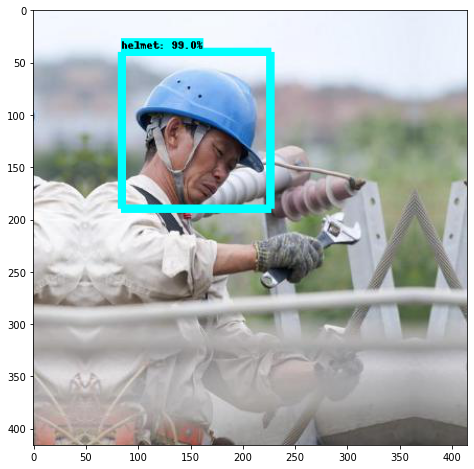

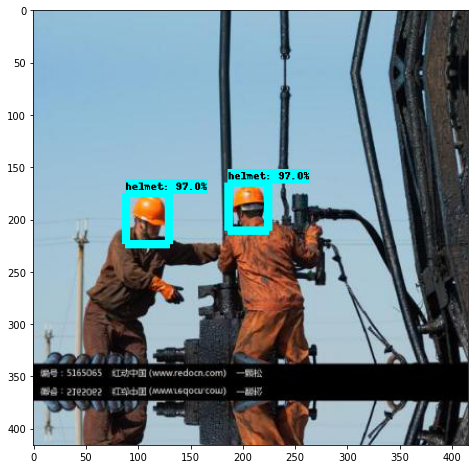

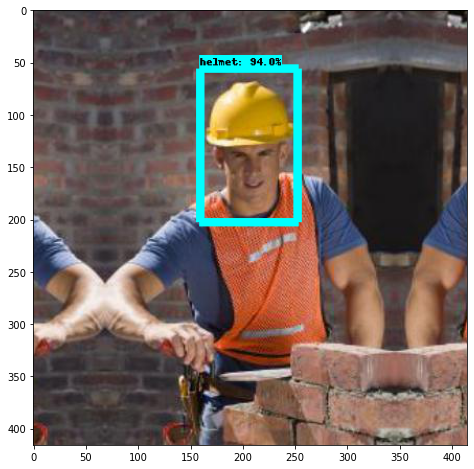

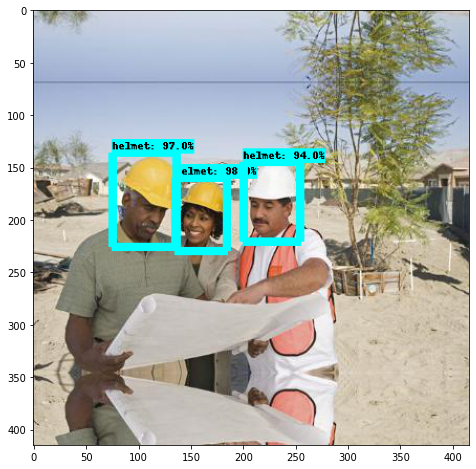

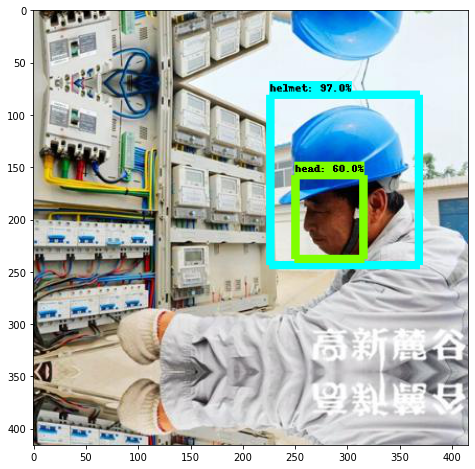

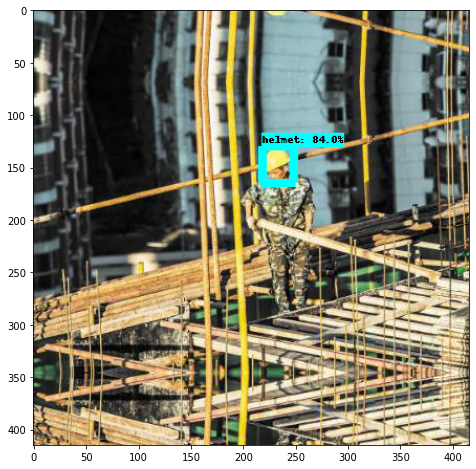

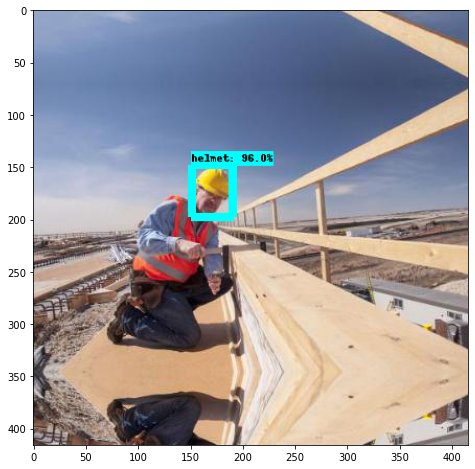

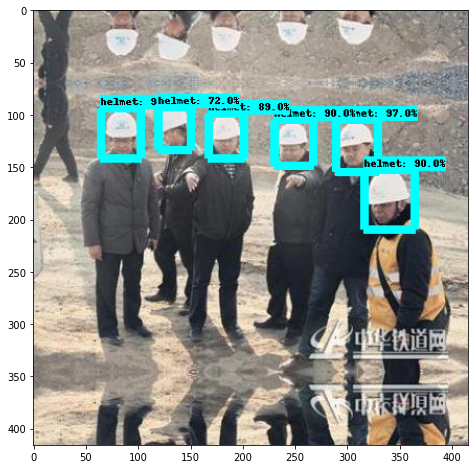

In [ ]:
# This is needed to display the images with bounding boxes.
for image_path in TEST_IMAGE_PATHS:
    image = Image.open(image_path)
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = load_image_into_numpy_array(image)
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks'),
        use_normalized_coordinates=True,
        line_thickness=8)
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image_np)